In [5]:
import tgt
import glob
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
import tensorflow as tf
import os
import re
import textdistance
import Levenshtein as lev
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cityblock

In [6]:
gpu_available = tf.test.is_gpu_available()
is_cuda_gpu_available = tf.test.is_gpu_available(cuda_only=True)
is_cuda_gpu_min_3 = tf.test.is_gpu_available(True, (3,0))
print(gpu_available)
print(is_cuda_gpu_available)
print(is_cuda_gpu_min_3)

True
True
True


In [7]:
VOWEL=['i', 'y', 'e', 'ɛ',  'a', 'ɨ', 'ə', 'u', 'o', 'ɔ', 'ɤ','ɚ']
CONSONENT=['p', 'pʰ', 'm', 'f', 't', 'tʰ', 'n', 'l', 's', 'ʂ', 'ʐ', 'ts', 'tsʰ', 'tʂ', 'tʂʰ', 'ɕ', 'tɕ', 'tɕʰ', 'k', 'kʰ', 
           'ŋ',  'x', 'j', 'ɥ', 'w']
 

In [8]:
class phfeat():
    def __distance__(self):
        for p in VOWEL:
            for q in VOWEL:
                pp = self.vowdf[p].to_numpy().astype(int)
                qq = self.vowdf[q].to_numpy().astype(int)

                self.vdist[p][q] = cityblock(pp,qq)
                
        for p in CONSONENT:
            for q in CONSONENT:
                pp = self.condf[p].to_numpy().astype(int)
                qq = self.condf[q].to_numpy().astype(int)

                self.cdist[p][q] = cityblock(pp,qq)

    def __xor__(self):
        for p in VOWEL:
            for q in VOWEL:
                pp = self.vowdf[p].to_numpy().astype(int)
                qq = self.vowdf[q].to_numpy().astype(int)
                xdiff = np.bitwise_xor(pp, qq)                        
                self.vxor[p][q] = [ self.features[i] for i in range(len(xdiff)) if xdiff[i] == 1 ]

        for p in CONSONENT:
            for q in CONSONENT:
                pp = self.condf[p].to_numpy().astype(int)
                qq = self.condf[q].to_numpy().astype(int)
                xdiff = np.bitwise_xor(pp, qq)                        
                self.cxor[p][q] = [ self.features[i] for i in range(len(xdiff)) if xdiff[i] == 1 ]
                
        #print(self.vxor)
        #print(self.cxor)

    def __init__(self):
        self.condf = pd.read_excel('phoneme features.xlsx', engine='openpyxl', sheet_name="consonent")
        self.vowdf = pd.read_excel('phoneme features.xlsx', engine='openpyxl', sheet_name="vowel")
    
        del self.condf[self.condf.columns[0]]
        self.features=self.condf[self.condf.columns[0]].tolist()[:-1]
        #print("<><><>", self.features)
        
        del self.condf[self.condf.columns[0]]
        self.condf=self.condf[:-1]
        
        del self.vowdf[self.vowdf.columns[0]]
        del self.vowdf[self.vowdf.columns[0]]
        self.vowdf=self.vowdf[:-1]
        
        self.vdist = pd.DataFrame(index=VOWEL,columns=VOWEL)
        self.cdist = pd.DataFrame(index=CONSONENT,columns=CONSONENT)
        self.vxor = pd.DataFrame(index=VOWEL,columns=VOWEL)
        self.cxor = pd.DataFrame(index=CONSONENT,columns=CONSONENT)
        self.__distance__()
        self.__xor__()
        
        #del self.condf[self.condf.rows[-1]]
        
        #self.condft=self.condf.transpose()
        #self.vowft=self.vowdf.transpose()
        #self.condfnp = self.condft.to_numpy()
        #self.vowfnp = self.vowft.to_numpy()
        
        
    def print(self):
        #print(self.condf)
        #print(self.vowdf)
        print(self.vdist)
        print("----")
        print(self.cdist)

        
pf=phfeat()

pf.print()

   i  y  e  ɛ  a  ɨ  ə  u  o  ɔ  ɤ  ɚ
i  0  2  1  3  4  2  6  3  4  6  2  4
y  2  0  3  5  6  4  4  1  2  4  4  6
e  1  3  0  2  3  3  5  4  3  5  1  3
ɛ  3  5  2  0  1  3  3  6  5  3  3  1
a  4  6  3  1  0  4  4  7  6  4  4  2
ɨ  2  4  3  3  4  0  4  3  4  4  2  2
ə  6  4  5  3  4  4  0  3  2  0  4  2
u  3  1  4  6  7  3  3  0  1  3  3  5
o  4  2  3  5  6  4  2  1  0  2  2  4
ɔ  6  4  5  3  4  4  0  3  2  0  4  2
ɤ  2  4  1  3  4  2  4  3  2  4  0  2
ɚ  4  6  3  1  2  2  2  5  4  2  2  0
----
      p  pʰ   m   f   t  tʰ   n   l   s   ʂ  ...  ɕ  tɕ tɕʰ  k  kʰ   ŋ  x   j  \
p     0   1   4   2   2   3   6   6   4   5  ...  7   7   8  5   6   9  7   8   
pʰ    1   0   5   3   3   2   7   7   5   6  ...  8   8   7  6   5  10  8   9   
m     4   5   0   4   6   7   2   4   6   7  ...  9  11  12  9  10   5  9   6   
f     2   3   4   0   4   5   6   6   2   3  ...  5   7   8  7   8   9  5   8   
t     2   3   6   4   0   1   4   4   2   3  ...  5   5   6  5   6   9  7   8   
tʰ    3   2   7

In [9]:
class ckip():
    def __init__(self):
        if not os.path.isdir("./data"):
            data_utils.download_data_gdown("./")
            print("Loading CKIP data...")
            
        # Load model
        self.ws = WS("./data")
        self.pos = POS("./data")
        self.ner = NER("./data")
    
    def pos_analysis(self, lst):
        word_sentence_list = self.ws(lst, sentence_segmentation=True)
        pos_sentence_list = self.pos(word_sentence_list)
        ner_sentence_list = self.ner(word_sentence_list, pos_sentence_list)
        return(word_sentence_list, pos_sentence_list, ner_sentence_list)

    def print_pos(self, sentence_list, word_sentence_list,  pos_sentence_list, ofp):
        for i, sentence in enumerate(sentence_list):
            #print(sentence, word_sentence_list[i],  pos_sentence_list[i])
            self.print_word_pos_sentence(sentence_list, word_sentence_list[i],  pos_sentence_list[i], ofp)

    # Show results
    def print_word_pos_sentence(self, sentence_list, word_sentence_list, pos_sentence_list, ofp):
        assert len(word_sentence_list) == len(pos_sentence_list)
        for word, pos in zip(word_sentence_list, pos_sentence_list):
            print(f"{word}({pos})", end="\u3000")
            ofp.write(f"{word}({pos}) ")
        print()
        ofp.write("\n")

#ca = ckip()
#ca.pos_analysis(["我記得今年暑假和一位墨西哥裔朋友Hellen聊天，她說關於去其他國家旅行，在她三歲後除了美國，哪裡都不能去。"])

In [10]:
def contains_chinese(check_str):
    """
    判断字符串中是否包含中文
    :param check_str: {str} 需要检测的字符串,
    :return: {bool} 包含返回True， 不包含返回False
    """
    #print(check_str, end="")
    for ch in check_str:
        #print(ch)
        if not u'\u4e00' <= ch <= u'\u9fff':
            #print("False")
            return False
    #print("True")
    return True
    
contains_chinese("不一樣")

True

In [11]:
class thai_textgrid:
    def __init__(self, name):
        self.tg = tgt.read_textgrid(name, encoding='utf-16')
        #print(self.tg.get_tier_names())
        
    def parse_tiers(self):
        self.twtier = self.tg.get_tier_by_name("IU/teacher")
        #self.wttier = self.tg.get_tier_by_name("Word/teacher")
        self.tptier = self.tg.get_tier_by_name("IU/phone")
        self.tsytier = self.tg.get_tier_by_name("IU/syllable")
        self.swtier = self.tg.get_tier_by_name("IU/student")
        #self.swtier = self.tg.get_tier_by_name("Word/student")
        self.sptier = self.tg.get_tier_by_name("student IPA")
        self.ssytier = self.tg.get_tier_by_name("EU/syllable")

        #return self.twtier, self.tptier, self.tstier, self.tttier, self.swtier, self.sptier, self.sstier, self.sttier


In [12]:
def ttiter(tier):
    tword=[]
    for t in tier:
        #print(t.text, end=" ")
        ccstr=t.text.replace(" ","").replace("*","").replace("^","").replace("~","").replace("SIL","")
        if contains_chinese(ccstr) and ccstr != "" :
            #print("<--")
            tword.append(ccstr)

    return(tword)

In [13]:
def sterr_tier(tier):
    sword=[]
    for t in tier:
        #print(t.text, end=" ")
        ccstr=t.text.replace(" ","").replace("^","").replace("~","").replace("SIL","")
        if "*" in ccstr:
        #if contains_chinese(ccstr) and ccstr != "" :
            #print("<--")
            #print(ccstr)
            sword.append(ccstr)

    return(sword)

In [14]:
def tier_iter(tier):
    tword=[]
    for t in tier:
        print(t.text, end=" ")
        
        if contains_chinese(t.text):
            #print("<--")
            tword.append(t.text)
    tanswer=[]
    for w in tword:
        for i in range(len(w)):
            tanswer.append(w[i])
    return(tanswer)

In [15]:
def term_histogram(lst):
    for i in lst:
        xi = i.replace('SIL')
        

In [16]:
ca = ckip()

/home/chainwu/anaconda3/envs/thaiphone/lib/python3.6/site-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:901: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.LSTMCell` is deprecated and will be "
/home/chainwu/anaconda3/envs/thaiphone/lib/python3.6/site-packages/keras/engine/base_layer_v1.py:1684: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [17]:
%matplotlib inline
import numpy as np
#mport random
from matplotlib import pyplot as plt
import numpy as np

def hist_plot(data): 
    # fixed bin size
    labels, counts = np.unique(data,return_counts=True)
#     for i in range(len(labels)):
#         print(labels[i], ":", counts[i])
#     print()
        
    plt.rcParams['figure.figsize'] = [20, 10]
    
    ticks = range(len(counts))
    plt.bar(ticks,counts, align='center')
    plt.xticks(ticks, labels)
#    plt.figure().set_figwidth(15)
    #plt.figure(figsize=(20,12))

    plt.show()

In [18]:
#conf=[]
#conf=[]

def matrix_update(tp, sp, vconf, cconf, pf, verrl, cerrl, vlol, clol):
    #print(tp, sp)
    if (tp in VOWEL) or (tp == '∅' and sp in VOWEL):
        vconf.append([tp, sp])
        if tp != '∅' and sp in VOWEL:
            #print(tp, sp, pf.vdist[tp][sp])
            verrl.append(pf.vdist[tp][sp])
            vlol.append(pf.vxor[tp][sp])
    elif (tp in CONSONENT) or (tp == '∅' and sp in CONSONENT):
        cconf.append([tp, sp])
        if tp != '∅' and sp in CONSONENT:
            #print(tp, sp, pf.cdist[tp][sp])
            cerrl.append(pf.cdist[tp][sp])
            clol.append(pf.cxor[tp][sp])
    else:
        print("Something weird happened, tp=", tp, "sp=", sp)


In [19]:
def plot_task(conf):
    tvl = [z[0] for z in conf]
    svl = [z[1] for z in conf]
    tvlabel = set(tvl)
    svlabel = set(svl)
    
    df = pd.DataFrame(np.zeros((len(tvlabel), len(svlabel)), dtype=np.int), tvlabel, svlabel)
    
    for i in range(len(conf)):
        df.loc[tvl[i]][svl[i]]=df.loc[tvl[i]][svl[i]]+1
        
    #rint(df.shape)
    #print(df)
    plt.rcParams['figure.figsize'] = [25, 25]
    sn.set(font_scale=1.4)
    sn.heatmap(df, annot=True, cbar=False,cmap='turbo', fmt='g')
    
    plt.show()
    #plot3d(df)

    #ax.bar3d(df., dx=0.5, dy=0.5, dz=z, color=colors)
    #plt.show()


/opt/speech-data/NL_BKK_9.5/06272018_ZOOM0008-2.TextGrid.14
/opt/speech-data/NL_BKK_9.5/06282018_ZOOM0010.TextGrid.14
/opt/speech-data/NL_BKK_9.5/06262018_12tiers_未翻譯_done/06262018_ZOOM0006_LR_TextGrid.14
/opt/speech-data/NL_BKK_9.5/06262018_12tiers_未翻譯_done/06262018_ZOOM0005_LR.TextGrid.14
Something weird happened, tp= ∅ sp= v
Something weird happened, tp= ∅ sp= ʃ
Something weird happened, tp= ∅ sp= ʃ
Something weird happened, tp= ∅ sp= ʃ
Something weird happened, tp= ∅ sp= h
Something weird happened, tp= ∅ sp= v
Something weird happened, tp= ∅ sp= v
/opt/speech-data/NL_BKK_9.5/06262018_12tiers_未翻譯_done/06262018_ZOOM0007_LR.TextGrid.14
Something weird happened, tp= ∅ sp= h
Something weird happened, tp= ∅ sp= h
/opt/speech-data/NL_BKK_9.5/06192018_12tiers_未翻譯_done/ZOOM0002_1.TextGrid.14
Something weird happened, tp= ∅ sp= ɹ
Something weird happened, tp= ∅ sp= tʃʰ
Something weird happened, tp= ∅ sp= ʃ
Something weird happened, tp= ∅ sp= ʃ
Something weird happened, tp= ∅ sp= ɛ̃
Something

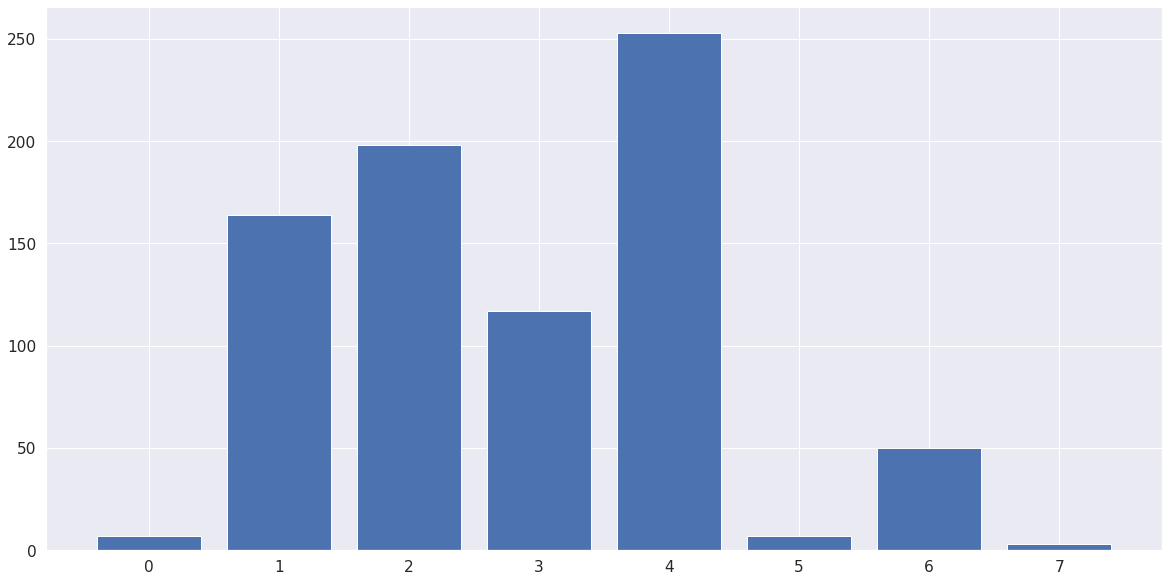

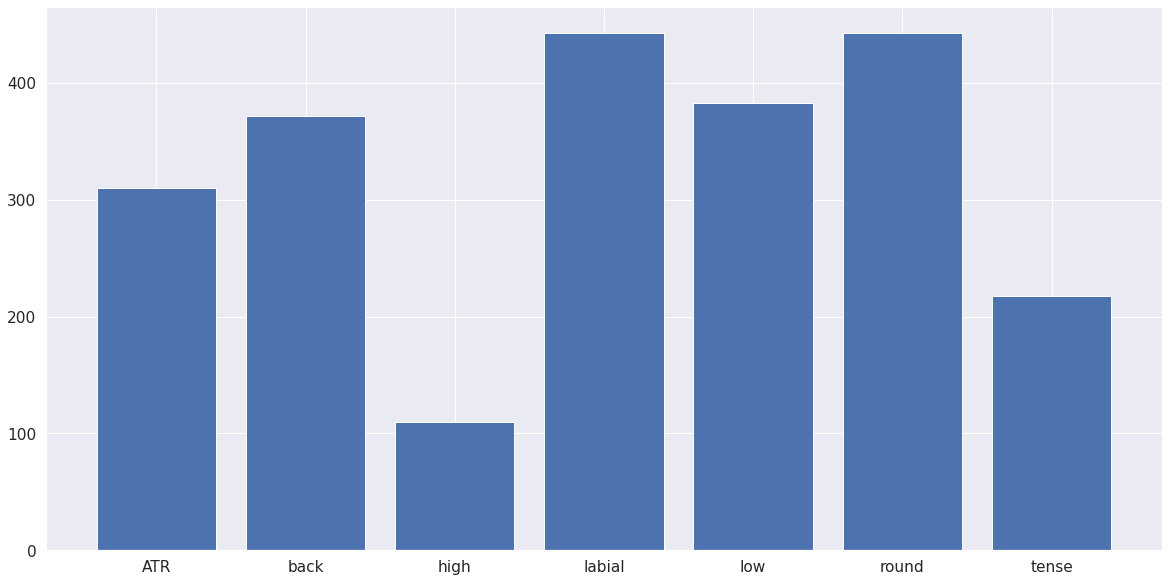

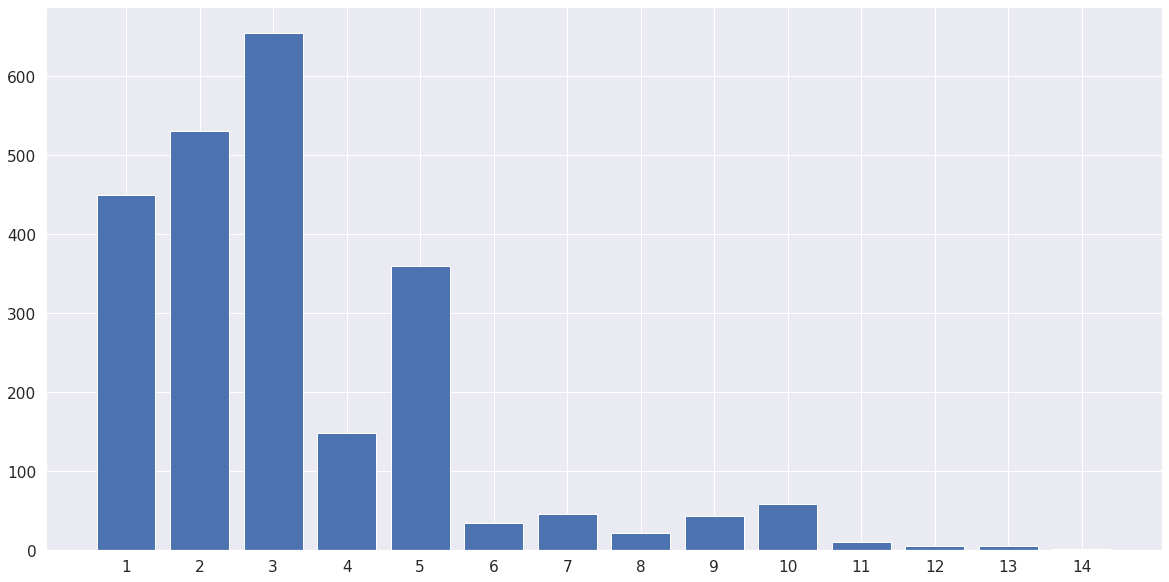

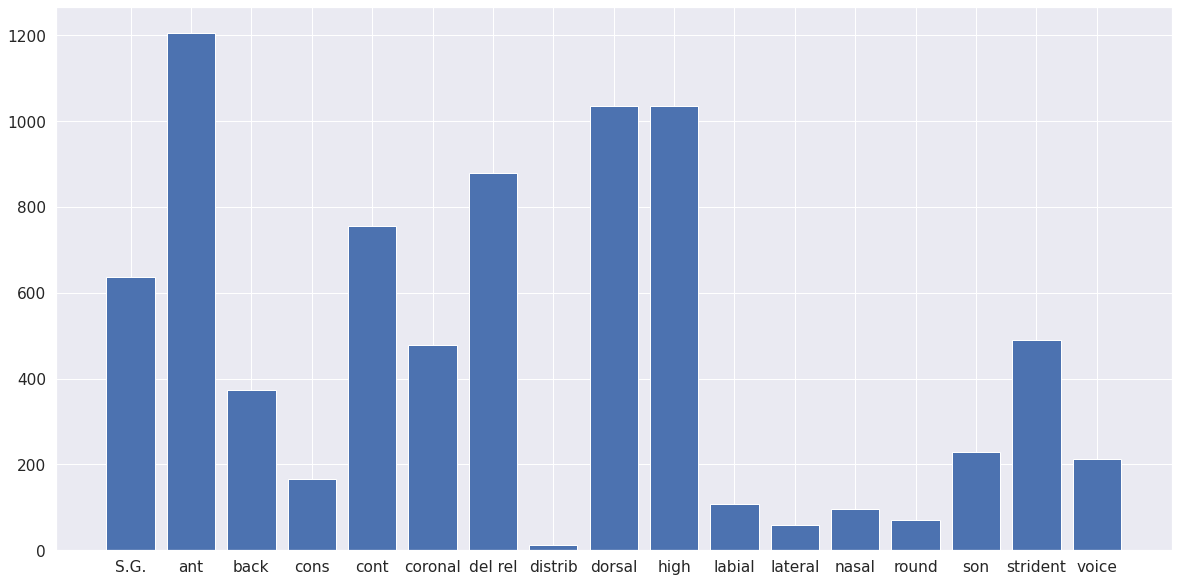

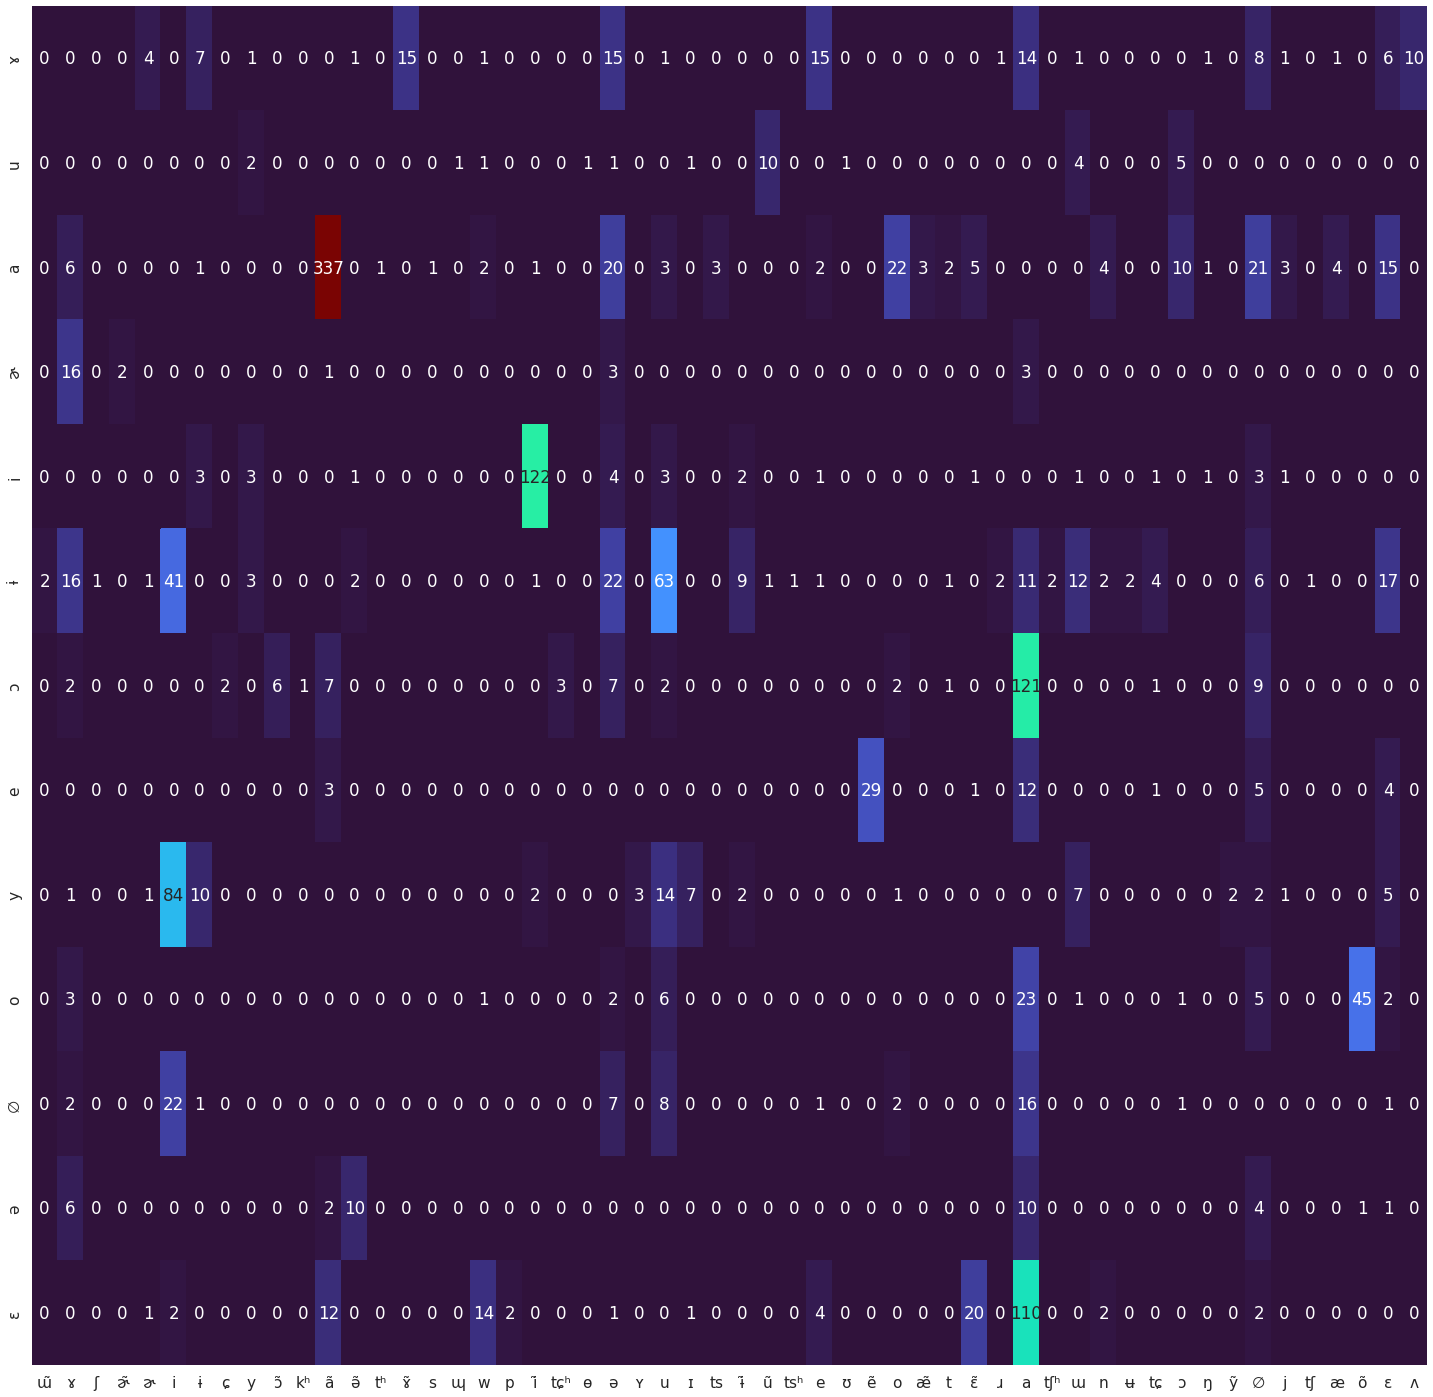

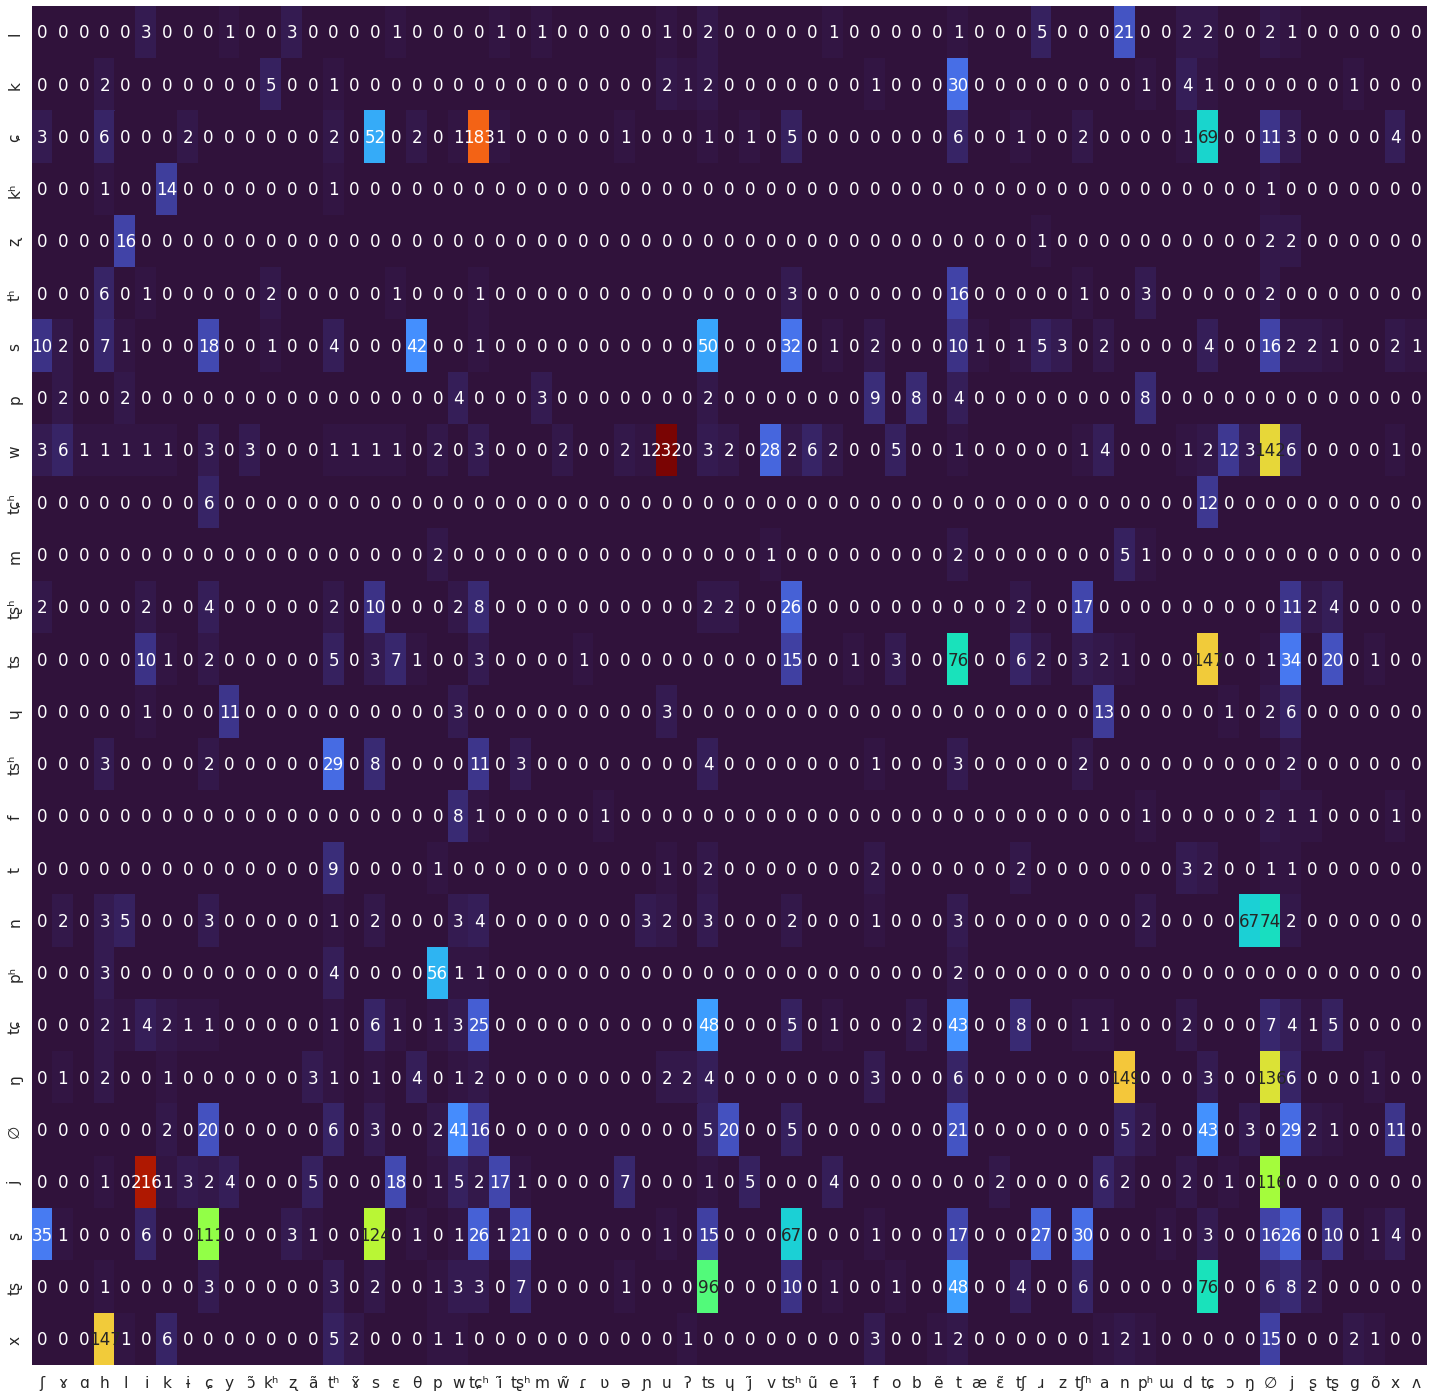

In [23]:
#print(vtrue, verr, ctrue, cerr)

def main():
    flist = glob.glob("/opt/speech-data/NL_BKK_9.5/**/*.14", recursive=True)
    vconf=[]
    cconf=[]
    verrl=[]
    cerrl=[]
    vlol=[]
    clol=[]
    
    pf=phfeat()
    
    for f in flist:
        print(f)
        tgf = thai_textgrid(f)
        tgf.parse_tiers()

        ttier = tgf.twtier
        tptier = tgf.tptier
        stier = tgf.swtier
        sptier = tgf.sptier
        tsytier = tgf.tsytier
        ssytier = tgf.ssytier
        
        #tword=ttiter(tier_list[0])
        #print(tword)
        
        #w,p,n = ca.pos_analysis(tword)
        #allw.append(w)
        #print(w)
        
        for t in stier:
            #print(t.text, end=" ")
            if "*" in t.text:
                # Student contains error
                ccstr=t.text.replace("*","").replace(" ","").replace("^","").replace("~","").replace("SIL","")
                pattern = "[0-9a-zA-Z\s]+"
                # perform a regex substitution to clean the string
                serrtxt=re.sub(pattern, "", ccstr)
                #print(t.text, serrtxt)
                pes=t.start_time
                pee=t.end_time
                #print(pes, pee)
                ttl = ttier.get_annotations_with_text(serrtxt, n=1)

                if len(ttl) != 0:
                    tes= ttl[0].start_time
                    tee= ttl[0].end_time
                    tpl = tptier.get_annotations_between_timepoints(tes, tee, left_overlap=True, right_overlap=True)
                    pepl = sptier.get_annotations_between_timepoints(pes, pee, left_overlap=True, right_overlap=True)
                    tsyl = tsytier.get_annotations_between_timepoints(tes, tee, left_overlap=True, right_overlap=True)
                    ssyl = ssytier.get_annotations_between_timepoints(pes, pee, left_overlap=True, right_overlap=True)
                    
                    tsystr = tsyl[0].text
                    ssystr = ssyl[0].text
                    
                    sydist = lev.distance(tsystr, ssystr)
                    syact = lev.editops(tsystr, ssystr)
                    
                    #print(tsystr, ssystr, sydist, syact)
                    
                    tp2 = [x.text for x in tpl]
                    pl2 = [x.text for x in pepl]
                    #print(tp2, pl2)
                    
                    #for x, y in zip(tp2, pl2):
                    #    if x != y:
                            #print(x, "->",y)
                            
                    lsn=lev.distance(tp2, pl2)
                    led=lev.editops(tp2, pl2)
                    #print(led)
                    for ac in led:
                        action = ac[0]
                        fstidx = ac[1]
                        sndidx = ac[2]
                        
                        if action == "replace":
                            #print(tp2[fstidx], "->", pl2[sndidx])
                            matrix_update(tp2[fstidx], pl2[sndidx], vconf, cconf, pf, verrl, cerrl, vlol, clol)
                        elif action == "delete":
                            #print(tp2[fstidx], "->[]")
                            matrix_update(tp2[fstidx], "∅", vconf,cconf, pf, verrl, cerrl, vlol, clol)
                        elif action == "insert":
                            #print("[]->", pl2[sndidx])
                            matrix_update("∅", pl2[sndidx], vconf, cconf, pf, verrl, cerrl, vlol, clol)
                        else:
                            print("No match")
    
    #print(vconf)
    #print(len(verrl), verrl)
    
    vflat = [item for sublist in vlol for item in sublist]
    cflat = [item for sublist in clol for item in sublist]
    #print(vflat)
    #print(cflat)
    
    hist_plot(verrl)
    hist_plot(vflat)
    #print(len(cerrl), cerrl)
    hist_plot(cerrl)
    hist_plot(cflat)
    
    plot_task(vconf)
    plot_task(cconf)
    

if __name__ == '__main__':
    main()  # 或是任何你想執行的函式
